# DIS background removal tool on Amazon SageMaker

In this notebook, we will implement asynchronous inferencing using the [DIS background removal tool](https://github.com/xuebinqin/DIS) in Amazon SageMaker. By using [Amazon SageMaker Asynchronous inference](https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference.html), you can process a large batch of images at scale with large payload sizes (up to 1GB) with near real-time latency. 

We will walkthrough on how to package a pre-train DIS model, implement the inferencing with a custom inference script and deploy out asynchronous endpoint.

**High Level Steps**
1. Package inference script, model and pre-train weights
2. Create SNS topics (optional) to record succcess/error messages from asynchronous inference
3. Create asynchronous configuration and deploy endpoint
4. Run Inference


In [267]:
# Install python dependencies
!pip install gdown

Keyring is skipped due to an exception: 'keyring.backends'

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [150]:
import os, gdown
import boto3
import sagemaker
from sagemaker.pytorch import PyTorch, PyTorchModel
import time
from time import gmtime, strftime
from datetime import datetime
import urllib
import numpy as np

In [68]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()  ### Replace with your own bucket if needed
role = sagemaker.get_execution_role(sagemaker_session)
prefix = "dis-background-removal"  ### Replace with the S3 prefix desired
region = boto3.Session().region_name
boto_session = boto3.session.Session()
sm_client = boto_session.client("sagemaker")
sm_runtime = boto_session.client("sagemaker-runtime")
sns_client = boto3.client('sns')
print(f"S3 bucket: {bucket}")
print(f"Role: {role}")
print(f"Region: {region}")

S3 bucket: sagemaker-us-west-2-686650353599
Role: arn:aws:iam::686650353599:role/service-role/AmazonSageMaker-ExecutionRole-20221207T104487
Region: us-west-2


## 1. Prepare package - Pre-train weights, model and code

In this section, we will:
    
1. Download the official pre-train weights
2. Download the DIS model from the git repository (https://github.com/xuebinqin/DIS)
3. Prepare our inference script
4. Package our model, weights and script
5. Upload package to S3


Anatomy of our package folder
- `model.pth` - Our pre-train model weights
- `/code/inference_script.py` - Our SageMaker inference script to be used. This overrides the default pytorch inferencing functionality with our own implementation.
- `/code/requirements.txt` - Inference script dependencies
- `/code/models` Folder containing the DIS model

In [272]:
# Define our model directory
model_artifact= os.path.join("s3://", bucket, prefix, "model.tar.gz")
model_artifact

's3://sagemaker-us-west-2-686650353599/dis-background-removal/model.tar.gz'

### 1.1 Download official pre-train weight

In [10]:
# Download official weights
if not os.path.exists("saved_models"):
    os.mkdir("saved_models")
    MODEL_PATH_URL = "https://drive.google.com/uc?id=1KyMpRjewZdyYfxHPYcd-ZbanIXtin0Sn"
    gdown.download(MODEL_PATH_URL, "saved_models/model.pth", use_cookies=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1KyMpRjewZdyYfxHPYcd-ZbanIXtin0Sn
From (redirected): https://drive.google.com/uc?id=1KyMpRjewZdyYfxHPYcd-ZbanIXtin0Sn&confirm=t&uuid=af0bf7bc-c527-42d9-a542-e9d5dea27240
To: /root/dis-background-removal-sagemaker/saved_models/model.pth
100%|██████████| 177M/177M [00:03<00:00, 52.2MB/s] 


### 1.2 Download DIS model

In [119]:
!mkdir model_and_code
!cp ./saved_models/model.pth ./model_and_code
!mkdir model_and_code/code

mkdir: cannot create directory ‘model_and_code’: File exists


In [115]:
!git clone https://github.com/xuebinqin/DIS

Cloning into 'DIS'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 328 (delta 64), reused 56 (delta 55), pack-reused 253
Receiving objects: 100% (328/328), 49.59 MiB | 19.09 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Checking out files: 100% (44/44), done.


#### Copy the model to the package folder

In [ ]:
!mv DIS/IS-Net/* ./model_and_code/code
!rm ./model_and_code/code/Inference.py
!rm ./model_and_code/code/requirements.txt

mv: cannot stat 'DIS/IS-Net/*': No such file or directory
rm: cannot remove './model_and_code/code/Inference.py': No such file or directory


### 1.3 Prepare infererncing script

As we will be using a custom pytoch model and mechanism for loading our data, we will need to implement custom functions for processing loading the model, processing the input, prediction and output. In this section, we will prepare and package our inferencing script (`./scripts/inference.py`). Let's have a look at the inference script below.

How to implement a custom inference script: https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#serve-a-pytorch-model

In [273]:
!pygmentize ./scripts/inference.py

import torch
import os
from torch.autograd import Variable
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from sagemaker_inference import encoder
from data_loader_cache import normalize, im_preprocess
from models import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from sys import getsizeof

class GOSNormalize(object):
    '''
    Normalize the Image using torch.transforms
    '''

    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        image = normalize(image, self.mean, self.std)
        return image


transform = transforms.Compose([GOSNormalize([0.5, 0.5, 0.5],[1.0, 1.0, 1.0])])


def input_fn(request_body, request_content_type):
    import io
    from PIL import Image
    
    # Read image as stream
    f = io.BytesIO(request_body)   
    input_image = Image.open(f).convert("RGB")
    
    # Read in and process image
  

#### Copy inference script to packaging folder

In [ ]:
!cp -r ./scripts/* model_and_code/code

### 1.4 Package code and model into model.tar.gz

In [249]:
!tar cvzf model.tar.gz -C model_and_code/ . 

./
./model.pth
./code/
./code/models/
./code/models/isnet.py
./code/models/__pycache__/
./code/models/__pycache__/u2netfast.cpython-37.pyc
./code/models/__pycache__/__init__.cpython-37.pyc
./code/models/__init__.py
./code/basics.py
./code/pytorch18.yml
./code/requirements.txt
./code/data_loader_cache.py
./code/.ipynb_checkpoints/
./code/.ipynb_checkpoints/requirements-checkpoint.txt
./code/inference.py
./code/train_valid_inference_main.py
./code/hce_metric_main.py
./code/__pycache__/
./code/__pycache__/basics.cpython-37.pyc
./code/__pycache__/data_loader_cache.cpython-37.pyc


### 1.5 Upload model and code to S3

In [250]:
!aws s3 cp model.tar.gz $model_artifact

upload: ./model.tar.gz to s3://sagemaker-us-west-2-686650353599/dis-background-removal/model.tar.gz


## 2. Create async endpoint

In this section we will walkthrough how to create an Amazon SageMaker Asynchronous endpoint. As part of the configuration, we will also create a SNS topic to capture the success and error events when invoking the asynchronous endpoint.

Reference: https://github.com/aws-samples/amazon-sagemaker-asynchronous-inference-computer-vision/blob/main/mask-rcnn-async-inference.ipynb

### Create SNS Error and Success topics

**Prerequisite**
Make sure IAM role has permission to create sns topics. For more information on required permissions, refer to the following documentation: https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference-create-endpoint-prerequisites.html

In [73]:
response = sns_client.create_topic(Name=f"{prefix}-Async-ErrorTopic")
error_topic= response['TopicArn']
print(error_topic)

arn:aws:sns:us-west-2:686650353599:dis-background-removal-Async-ErrorTopic


In [74]:
response = sns_client.create_topic(Name=f"{prefix}-Async-SuccessTopic")
success_topic = response['TopicArn']
print(success_topic)

arn:aws:sns:us-west-2:686650353599:dis-background-removal-Async-SuccessTopic


In [77]:
response = sns_client.list_topics()
topics = response["Topics"]
print(topics)

[{'TopicArn': 'arn:aws:sns:us-west-2:686650353599:DUSStack-dusstackjobcompletiontopic3jncj5mznfvxeahw8vnzazA02368F4-ESfqwypWqKrP'}, {'TopicArn': 'arn:aws:sns:us-west-2:686650353599:aws-controltower-SecurityNotifications'}, {'TopicArn': 'arn:aws:sns:us-west-2:686650353599:dis-background-removal-Async-ErrorTopic'}, {'TopicArn': 'arn:aws:sns:us-west-2:686650353599:dis-background-removal-Async-SuccessTopic'}]


### Create SageMaker Model with PyTorch inference conatiner

In [251]:
# Retrieve inference container
from sagemaker.image_uris import retrieve

deploy_instance_type = 'ml.m5.4xlarge'
pytorch_inference_image_uri = retrieve('pytorch',
                                       region,
                                       version='1.12',
                                       py_version='py38',
                                       instance_type = deploy_instance_type,
                                       accelerator_type=None,
                                       image_scope='inference')
print(pytorch_inference_image_uri)

763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-inference:1.12-cpu-py38


In [252]:
container = pytorch_inference_image_uri
model_name = 'sagemaker-maskrcnn-{0}'.format(str(int(time.time())))
print(container)
print(model_name)

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        'Image': container,
        'ModelDataUrl': model_artifact,
        'Environment': {
            'TS_MAX_REQUEST_SIZE': '100000000', #default max request size is 6 Mb for torchserve, need to update it to support the 70 mb input payload
            'TS_MAX_RESPONSE_SIZE': '100000000',
            'TS_DEFAULT_RESPONSE_TIMEOUT': '1000'
        }
    },    
)

763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-inference:1.12-cpu-py38
sagemaker-maskrcnn-1685939981


### Create Asynchronous inference endpoint

In [253]:
resource_name = "DISSegmentation-{}-{}"

endpoint_config_name = resource_name.format(
    "EndpointConfig", datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
)
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.m5.4xlarge",
            "InitialInstanceCount": 1,
        }
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": f"s3://{bucket}/{prefix}/output",
            # Optionally specify Amazon SNS topics
            "NotificationConfig": {
              "SuccessTopic": success_topic,
              "ErrorTopic": error_topic,
            }
        },
        "ClientConfig": {"MaxConcurrentInvocationsPerInstance": 4},
    },
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

Created EndpointConfig: arn:aws:sagemaker:us-west-2:686650353599:endpoint-config/dissegmentation-endpointconfig-2023-06-05-04-39-42


In [254]:
endpoint_name = f"sm-{prefix}-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
create_endpoint_response = sm_client.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
print(f"Creating Endpoint: {create_endpoint_response['EndpointArn']}")

Creating Endpoint: arn:aws:sagemaker:us-west-2:686650353599:endpoint/sm-dis-background-removal-2023-06-05-04-39-42


In [255]:
waiter = boto3.client('sagemaker').get_waiter('endpoint_in_service')
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=endpoint_name)
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
print(f"Endpoint Status: {resp['EndpointStatus']}")

Waiting for endpoint to create...
Endpoint Status: InService


## 3. Inference

Now that our endpoint is in service, let us run some inference and retrieve the results.

Note: In our inference script we can configured it to save the raw mask in a json and we will need to convert it into to preview our results as shown below. If you do want to modify how the inference script save your output, you can implement it in the `output_fn()` in the `scripts/inference.py` file.

In [256]:
def upload_file(input_location, prefix):
    prefix = f"{prefix}/input"
    return sagemaker_session.upload_data(
        input_location, 
        bucket=sagemaker_session.default_bucket(),
        key_prefix=prefix, 
        extra_args={"ContentType": "image/jpg"})

In [257]:
input_1_location = "data/sample.jpg"
input_1_s3_location = upload_file(input_1_location, prefix)

In [258]:
print(input_1_s3_location)

s3://sagemaker-us-west-2-686650353599/dis-background-removal/input/sample.jpg


In [259]:
print(endpoint_name)

sm-dis-background-removal-2023-06-05-04-39-42


### Invoke asynchronous inference

In [260]:
response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_1_s3_location)
output_location = response['OutputLocation']
print(f"OutputLocation: {output_location}")

OutputLocation: s3://sagemaker-us-west-2-686650353599/dis-background-removal/output/234eeae3-0a9b-4941-b637-1ec60850c730.out


In [261]:
from botocore.exceptions import ClientError

def get_output(output_location):
    output_url = urllib.parse.urlparse(output_location)
    bucket = output_url.netloc
    key = output_url.path[1:]
    while True:
        try:
            return sagemaker_session.read_s3_file(bucket=output_url.netloc, key_prefix=output_url.path[1:])
        except ClientError as e:
            if e.response['Error']['Code'] == 'NoSuchKey':
                print("waiting for output...")
                time.sleep(2)
                continue
            raise

In [262]:
output = get_output(output_location)
print(f"Output size in bytes: {((sys.getsizeof(output)))}")

waiting for output...
Output size in bytes: 2053765


### Download inference results and preview

In [263]:
## Download
!aws s3 cp $output_location ./output

download: s3://sagemaker-us-west-2-686650353599/dis-background-removal/output/234eeae3-0a9b-4941-b637-1ec60850c730.out to output/234eeae3-0a9b-4941-b637-1ec60850c730.out


In [264]:
print(os.path.basename(output_location))

234eeae3-0a9b-4941-b637-1ec60850c730.out


In [265]:
import json
from PIL import Image

with open(os.path.join("output", os.path.basename(output_location)), "rb") as f:
    data = json.load(f)

payload = np.asarray(data)
pil_mask = Image.fromarray(payload.astype('uint8')).convert('L')

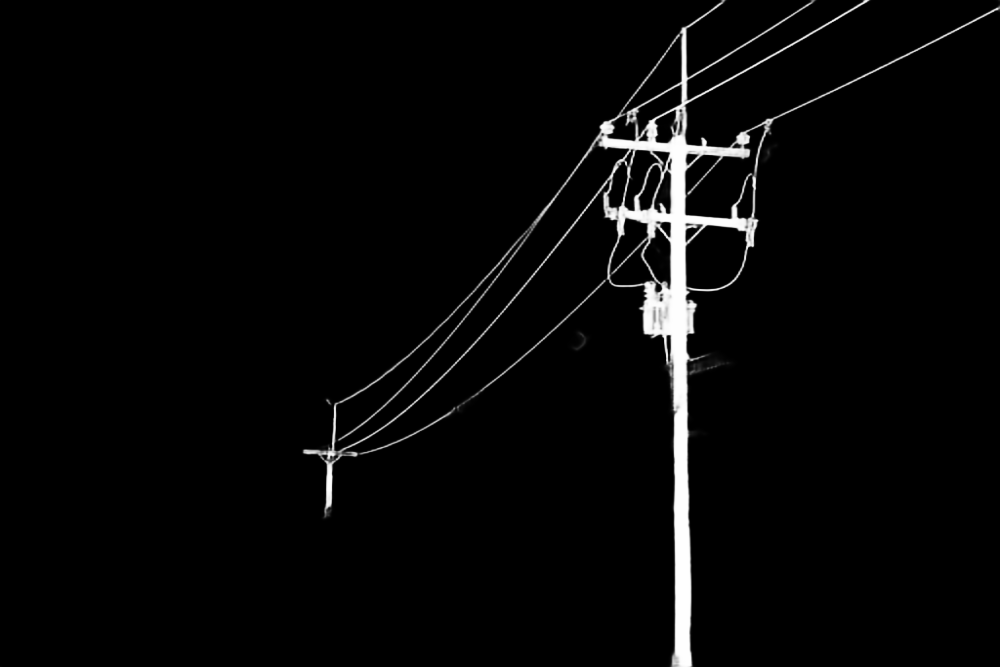

In [266]:
pil_mask

## 4. Clean up

Delete async endpoint

In [246]:
sm_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '5cc052b8-a372-42d7-8fc9-8143717c3c0b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '5cc052b8-a372-42d7-8fc9-8143717c3c0b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 05 Jun 2023 04:39:02 GMT'},
  'RetryAttempts': 0}}